In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import sys
import numpy as np
import seaborn as sns
import scipy.optimize as op
from scipy.signal import argrelmax
from scipy.signal import argrelmin
from scipy.optimize import curve_fit
sns.set_palette("PuBuGn_d",15)
sns.set_style("whitegrid")
import emcee
import numpy.polynomial.polynomial as poly

In [3]:
#cfile = open('/Users/elerath/Downloads/software/data/raw_data/20170906_1320_FTS2_shimmed_septum_choppedref1.pkl', 'rb')

cfile = open('/Users/elerath/Downloads/software/data/raw_data/20171013_1858_135GHz_beam_33.pkl')

d = pickle.load(cfile)
cfile.close()

#d_135 = pickle.load(cfile_135)
#cfile_135.close()

In [4]:
print d.keys()

print d['samples requested']
print d['max_d']

['wlf0R', 'wlf0F', 'oversample', 'ADC gain', 'scan time', 'iterations', 'scan start struct_time', 'speed', 'acceleration', 'max_d', 'max_nu', 'run', 'delay0F', 'dx', 'delay0R', 'sample freq', 'sig0R', 'scan0F', 'acc time', 'samples requested', 'sig0F', 'scan0R']
1921
75.0


In [5]:
#find maxima in the signal
maxima = argrelmax(d['sig0F'])
#convert from tuple to list
maxima = list(maxima[0])

sig0F = list(d['sig0F'])
#sig135 = list(d_135['sig0F'])

dx = d['dx']
#0.03125
x = [it * dx for it in maxima]
x = np.array(x)

max_sig = [sig0F[i] for i in maxima]
max_sig = np.array(max_sig)

In [6]:
#this function gets the points to be used for finding the parabola
def get_vals(index, signal):
    below = index - 1
    above = index + 1
    b_y = signal[below]
    a_y = signal[above]
    y = signal[index]
    below *= dx
    above *= dx
    index *= dx
    return ( (below, b_y), (index, y), (above, a_y) )


#given a tuple, find the equation of the parabola
def make_p(index, signal):
    points = get_vals(index, signal)
    y_vals = [ points[0][1], points[1][1], points[2][1]]
    x1 = points[0][0]
    x2 = points[1][0]
    x3 = points[2][0]
    matrix_a = [ [ x1*x1, x1, 1], [x2*x2, x2, 1], [x3*x3, x3, 1]]
    a_inverse = np.linalg.inv(matrix_a)
    a_inverse = np.matrix.transpose(a_inverse)
    matrix_p = np.matmul(y_vals, a_inverse) #THIS IS THE LINE WHERE IT GOES WRONG!!!!!
    return matrix_p

#this finds the vertex of our parabola from above aka it finds the point you want to plot
def parabola_vertex_h(index, signal):
    p = make_p(index, signal)
    h = -(p[1]) / (2*p[0])
    return h

def parabola_vertex_k(index, signal):
    p = make_p(index, signal)
    h = parabola_vertex_h(index, signal)
    k = p[0]*h*h + p[1]*h + p[2]
    return k

def shift_parabola(parabola, h):
    ret = parabola
    ret[0] = ret[0] + parabola[2]*h*h - parabola[1]*h
    ret[1] = ret[1] -2*parabola[2]*h
    return ret

def normalize_parabola(p):
    h = -(p[1]) / (2*p[2])
    k = p[2]*h*h + p[1]*h + p[0]
    p[0] = p[0]/k
    p[1] = p[1]/k
    p[2] = p[2]/k
    return p
    

(68,)
(68,)


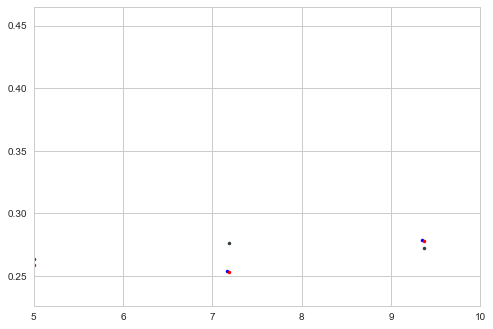

In [7]:
#applying the above functions to our fit

xvals = [parabola_vertex_h(i, sig0F) for i in maxima]

xvals = np.array(xvals)

print x.shape
print max_sig.shape

diffx = xvals - x

max_sig_fit = [parabola_vertex_k(i, sig0F)for i in maxima]


plt.xlim([5, 10])

plt.plot(xvals, max_sig_fit, "b.")

plt.plot(x, max_sig, "r.")

plt.plot(x, xvals - x + .3, ".")


In [8]:
very_simple_ex = np.array([-4, -1, 0 , -1, -4])

simple_max = argrelmax(very_simple_ex)

simple_max = simple_max[0]

g = get_vals(2, very_simple_ex)
print "these are very simple points"
print g

p = make_p(2, very_simple_ex)
print "should be y= −x^2+4.000x−4.000"
print p

print "checking verticies"
h = parabola_vertex_h(2, very_simple_ex)
k = parabola_vertex_k(2, very_simple_ex)
print h
print k

these are very simple points
((0.078125, -1), (0.15625, 0), (0.234375, -1))
should be y= −x^2+4.000x−4.000
[-163.84   51.2    -4.  ]
checking verticies
0.15625
-8.881784197e-16


In [9]:
# plotting points and their respective parabolas

close_to_fit = argrelmin(diffx)
print(close_to_fit)

far_from_fit = argrelmax(diffx)
print(far_from_fit)

# pick index 72 as close point,73 as far point
#it is interesting to note that these are always only 1 index off 


close_points = get_vals(maxima[213], sig0F)
far_points = get_vals(maxima[214], sig0F)
print close_points
print far_points

closefitp = make_p(maxima[213], sig0F)

farfitp = make_p(maxima[214], sig0F)

close_vertex = (parabola_vertex_k(maxima[213], sig0F), parabola_vertex_k(maxima[213], sig0F))
#the last point of the close_fit set is always very very different hmmmm interesting to note
far_vertex = (parabola_vertex_k(maxima[214], sig0F), parabola_vertex_k(maxima[214], sig0F))


(array([ 2,  5, 10, 12, 14, 17, 20, 22, 24, 28, 31, 35, 40, 45, 47, 49, 51,
       56, 59, 61, 63, 65]),)
(array([ 1,  3,  6, 11, 13, 15, 19, 21, 23, 26, 29, 33, 36, 43, 46, 48, 50,
       53, 57, 60, 62, 64, 66]),)


IndexError: list index out of range

In [10]:
#plotting the close fit 

t = np.linspace(39.8, 39.9, 1000)
f = closefitp[0]*t*t + closefitp[1]*t + closefitp[2]


ax = plt.figure()
ax = ax.add_subplot(111)

ax.plot(t, f, 'b-', label='sin(t)')

ax.scatter(*zip(*close_points))

plt.savefig('close_fit.pdf')


NameError: name 'closefitp' is not defined

In [11]:
#plotting the far fit 

tf = np.linspace(39.95, 40.05, 1000)
ff = farfitp[0]*tf*tf + farfitp[1]*tf + farfitp[2]


ax1 = plt.figure()
ax1 = ax1.add_subplot(111)

ax1.plot(tf, ff, 'b-', label='sin(t)')

ax1.scatter(*zip(*far_points))

plt.savefig('far_fit.pdf')

NameError: name 'farfitp' is not defined

ValueError: x and y must have same first dimension, but have shapes (3199,) and (1957,)

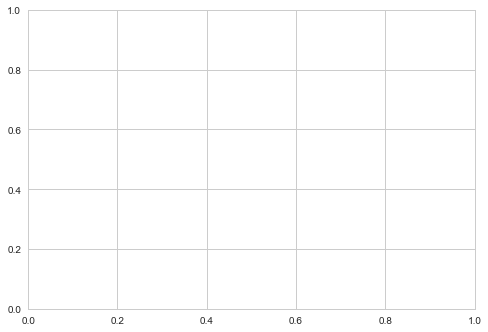

In [12]:
#allx = np.linspace(0, 100, 3199)

allx = np.arange(3199)*0.03125

ax2 = plt.figure()
ax2 = ax2.add_subplot(111)

ax2.plot(allx, list(sig0F), 'g.', label="all the data")
ax2.plot(allx, list(sig0F), 'b.', label="all the data")
ax2.plot(xvals, max_sig_fit, "y.")

ax2.plot(x, max_sig, "r.")

#pl.xlim([6.7, 7.1])
plt.ylim([-.5, 0.5])

allx_maxes = [allx[i] for i in maxima]


print 


[  2.20488144e-01   5.74234742e-03  -3.84910482e-05]


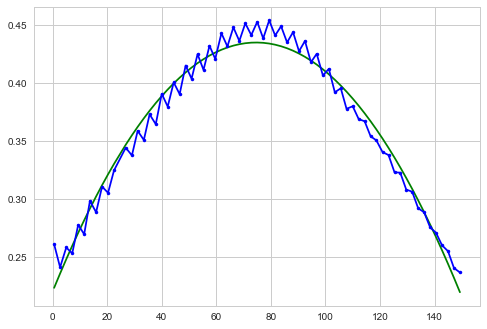

In [13]:
#finding 2nd degree best fit function

#in the order c, bx, ax^2
abc = poly.polyfit(x, max_sig, 2)
print abc

def polyfit_eq(x, abc):
    return abc[2]*x*x + abc[1]*x + abc[0]

ax3 = plt.figure()
ax3 = ax3.add_subplot(111)

ax3.plot(x, polyfit_eq(x, abc), 'g-', label="all the data")
ax3.plot(x, max_sig, 'b.-', label="all the data")

plt.savefig("polyfit.pdf")

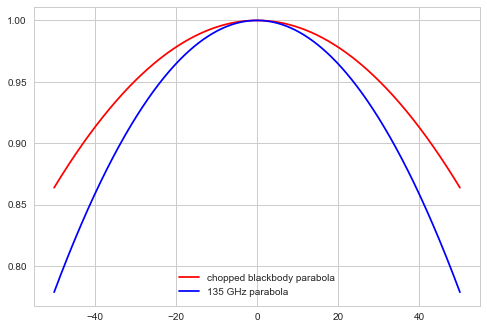

In [42]:
#Comparing 135 GHz and chopped blackbody

chopped_p = [3.28335110 * 10**(-1),
             2.95998001 * 10**(-3),
             -2.30694399 * 10**(-5)]

f135_p = [2.20488144 * 10**(-1),
          5.74234242 * 10**(-3),
          -3.84910482 *10**(-5)]

xr = np.linspace(-50.0, 50.0, 1000)

shift_chopped_amt_lr = -(chopped_p[1]) / (2*chopped_p[2])
shift_f135_amt_lr = -(f135_p[1]) / (2*f135_p[2])

chopped_p_shifted_lr = shift_parabola(chopped_p, -1*shift_chopped_amt_lr)
f135_p_shifted_lr = shift_parabola(f135_p, -1*shift_f135_amt_lr)

shift_chopped_amt =  ((shift_chopped_amt_lr**2)*chopped_p[2] + shift_chopped_amt_lr *chopped_p[1] +chopped_p[0])
shift_f135_amt = ((shift_f135_amt_lr**2)*f135_p[2] + shift_f135_amt_lr *f135_p[1] +f135_p[0])

chopped_p_normalized = normalize_parabola(chopped_p_shifted_lr)
f135_p_normalized = normalize_parabola(f135_p_shifted_lr)

ax4 = plt.figure()
ax4 = ax4.add_subplot(111)

ax4.plot(xr, polyfit_eq(xr, chopped_p_normalized), 'r-', label="chopped blackbody parabola")
ax4.plot(xr, polyfit_eq(xr, f135_p_normalized), 'b-', label="135 GHz parabola")
ax4.legend()